In [2]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

from IPython.display import display, IFrame

def merging_animation():
    src="https://docs.google.com/presentation/d/e/2PACX-1vSk2FfJ4K_An_CQwcN_Yu5unpJckOZjVQDFqZ78ZTTMmowUsCQKKVnum0_m6TaiGquQ44E3FiS9g2Y4/embed?start=false&loop=false&delayms=60000"
    width=825
    height=500
    display(IFrame(src, width, height))

# Lecture 10 – Grouping with Subgroups, Merging

## DSC 10, Fall 2022

### Announcements

- Lab 3 is due **tomorrow at 11:59PM**.
- Homework 3 is due on **Tuesday 10/18 at 11:59PM**.
- The Midterm Project will be released Wednesday!
    - Partners are not required, but strongly encouraged.
    - Your partner doesn't have to be from your lecture section.
    - Before or after discussion on Monday, we'll host a mixer to help you find a partner! More details soon.
    - You must use the [pair programming](https://dsc10.com/pair-programming/) model when working with a partner.
- If you have a **conflict** with your assigned discussion, email TA Dasha (dveraksa@ucsd.edu) to request to attend another.
- EdStem posts:
    - If it includes code or your solution, post privately.
    - Otherwise, post in the designated thread for the corresponding HW/Lab question.

### Agenda

- Grouping with subgroups.
- Merging.

## Grouping with subgroups

### DSC 10 student data

In [3]:
roster = bpd.read_csv('data/roster-anon.csv')
roster

,name,section
0,Levy Dmxsqj,11AM
1,Aiden Nyozzx,1PM
2,Sruti Fivolq,12PM
...,...,...
408,Leni Hlfjhh,11AM
409,Dory Xaghsk,1PM
410,Laura Xfqwzu,11AM


Recall, last class, we extracted the first name of each student in the class.

In [4]:
def first_name(full_name):
    '''Returns the first name given a full name.'''
    return full_name.split(' ')[0]

In [5]:
with_first = roster.assign(
    first=roster.get('name').apply(first_name)
)
with_first

,name,section,first
0,Levy Dmxsqj,11AM,Levy
1,Aiden Nyozzx,1PM,Aiden
2,Sruti Fivolq,12PM,Sruti
...,...,...,...
408,Leni Hlfjhh,11AM,Leni
409,Dory Xaghsk,1PM,Dory
410,Laura Xfqwzu,11AM,Laura


### How many students named `'Ethan'` are in each section?

We discovered that `'Ethan'` is the most popular first name overall.

In [12]:
first_counts = (with_first.groupby('first').count()
                .sort_values('name', ascending=False)
                .get(['name']))
first_counts

,name
first,
Ethan,5
Steven,4
Jason,4
...,...
Huanchang,1
Housheng,1
Zoya,1


To find the number of `'Ethan'`s in each lecture section, we can query for only the rows corresponding to `'Ethan'`s, and then group by `'section'`.

In [14]:
with_first[with_first.get('first') == 'Ethan'].groupby('section').count()

,name,first
section,,
10AM,1,1
11AM,1,1
1PM,3,3


But what if we want to know the number of `'Emily'`s and `'Yuen'`s per section, too?

In [15]:
with_first[with_first.get('first') == 'Emily'].groupby('section').count()

,name,first
section,,
10AM,1,1
1PM,1,1


In [16]:
with_first[with_first.get('first') == 'Yuen'].groupby('section').count()

,name,first
section,,
1PM,2,2


Is there a way to do this **for all first names and sections** all at once?

### How many students with each first name does each lecture section have?

- It seems like grouping would be helpful here, but currently we only know how to group by a single column.
    - Right now, we can count the number of students with each first name.
    - Separately, we can count the number of students in each lecture section.

- Here, we want to somehow group by multiple columns. 
    - Specifically, we want the number of students with each first name in each lecture section.
    - e.g. the number of `'Ethan'`s in the 1PM section, the number of `'Emily'`s in the 10AM section.

- **We can!**

In [17]:
with_first

,name,section,first
0,Levy Dmxsqj,11AM,Levy
1,Aiden Nyozzx,1PM,Aiden
2,Sruti Fivolq,12PM,Sruti
...,...,...,...
408,Leni Hlfjhh,11AM,Leni
409,Dory Xaghsk,1PM,Dory
410,Laura Xfqwzu,11AM,Laura


In [18]:
with_first.groupby(['section', 'first']).count()

name
section first       
10AM    Adrian     1
        Ahmed      1
        Akshay     1
...              ...
1PM     Zilu       1
        Ziwei      1
        Ziyu       1

[393 rows x 1 columns]

The above DataFrame is telling us, for instance, that there is 1 student with the first name `'Adrian'` in the 10AM section.

It is **not** saying that there is only 1 `'Adrian'` in the course overall – in fact, there are 2!

In [20]:
with_first[with_first.get('first') == 'Adrian']

,name,section,first
37,Adrian Yombcy,10AM,Adrian
332,Adrian Rxppvf,11AM,Adrian


### `.groupby` with subgroups

- To make subgroups – that is, groups within groups – pass a **list** of column names to `.groupby`:

<br>

<center><code>df.groupby([col_1, col_2, ..., col_k])</code></center>


- Group by `col_1` first.
- Within each group, group by `col_2`, and so on.
- The resulting DataFrame has one row per unique combination of entries in the specified columns.

### Notice the index... 🤔

- This is called a "[MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)".
    - The DataFrame is indexed by `'section'` **and** `'first'`.
- We won't worry about the details of MultiIndexes.
- We can use `.reset_index()` to "flatten" our DataFrame back to normal.

In [19]:
with_first.groupby(['section', 'first']).count().reset_index()

,section,first,name
0,10AM,Adrian,1
1,10AM,Ahmed,1
2,10AM,Akshay,1
...,...,...,...
390,1PM,Zilu,1
391,1PM,Ziwei,1
392,1PM,Ziyu,1


### Does order matter?

In [21]:
with_first.groupby(['section', 'first']).count().reset_index()

,section,first,name
0,10AM,Adrian,1
1,10AM,Ahmed,1
2,10AM,Akshay,1
...,...,...,...
390,1PM,Zilu,1
391,1PM,Ziwei,1
392,1PM,Ziyu,1


In [22]:
with_first.groupby(['first', 'section']).count().reset_index()

,first,section,name
0,Aaron,11AM,1
1,Abdulrahim,11AM,1
2,Abigail,11AM,1
...,...,...,...
390,Ziyu,1PM,1
391,Zoey,11AM,1
392,Zoya,11AM,1


**Answer:** Kind of. The order of the rows and columns will be different, but the content will be the same.

### Activity

Using `counts`, find the lecture section with the most `'Ryan'`s.

In [23]:
counts = with_first.groupby(['section', 'first']).count().reset_index()
counts

,section,first,name
0,10AM,Adrian,1
1,10AM,Ahmed,1
2,10AM,Akshay,1
...,...,...,...
390,1PM,Zilu,1
391,1PM,Ziwei,1
392,1PM,Ziyu,1


In [26]:
counts[counts.get('first') == "Ryan"].sort_values(by = 'name', ascending=False)

,section,first,name
362,1PM,Ryan,2
89,10AM,Ryan,1
271,12PM,Ryan,1


### Activity

Using `counts`, find the longest first name in the class that is shared by at least two students in the same section.

*Note*: This was an activity in the last class. There, we had to use our `shared_first_and_section` function; that's not needed here!

In [28]:
counts_more_than_two = counts[counts.get('name') > 1]

In [31]:
counts_more_than_two.assign(length = counts_more_than_two.get('first').apply(len)).sort_values(by = 'length', ascending = False)

,section,first,name,length
163,11AM,Jessica,2,7
263,12PM,Matthew,2,7
8,10AM,Andrew,3,6
...,...,...,...,...
195,11AM,Owen,2,4
362,1PM,Ryan,2,4
386,1PM,Yuen,2,4


### New dataset: Sea temperatures 🌊

This dataset contains the sea surface temperature in La Jolla, on many days ranging from August 22, 1916 to December 31, 2020.

In [32]:
sea_temp = bpd.read_csv('data/sea_temp.csv')
sea_temp

,YEAR,MONTH,DAY,SURFACE_TEMP
0,1916,8,22,19.5
1,1916,8,23,19.9
2,1916,8,24,19.7
...,...,...,...,...
36839,2020,12,29,14.9
36840,2020,12,30,15.0
36841,2020,12,31,14.8


### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

We want to find the single month (e.g. November 1998) with the highest average `'SURFACE_TEMP'`.

Which of the following would help us achieve this goal?

A. `sea_temp.groupby('SURFACE_TEMP').mean()`

B. `sea_temp.groupby('MONTH').mean()`

C. `sea_temp.groupby(['YEAR', 'MONTH']).mean()`

D. `sea_temp.groupby(['MONTH', 'DAY']).mean()`

E. `sea_temp.groupby(['MONTH', 'SURFACE_TEMP']).mean()`

In [71]:
sea_temp.groupby(['YEAR', 'MONTH']).mean().reset_index().sort_values(by='SURFACE_TEMP', ascending=False).take([0])

,YEAR,MONTH,DAY,SURFACE_TEMP
1224,2018,8,15.9,24.73


### Plots of monthly and yearly average surface temperature 📈

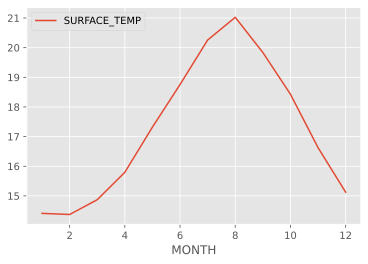

In [45]:
(sea_temp.groupby('MONTH').mean() 
 .plot(kind='line', y='SURFACE_TEMP')
);

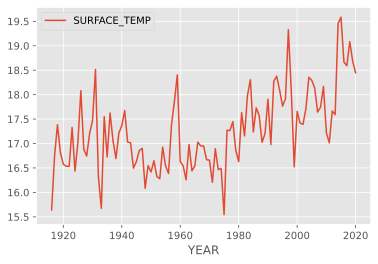

In [46]:
(sea_temp
 .groupby('YEAR') 
 .mean() 
 .plot(kind='line', y='SURFACE_TEMP')
);

### Summary: `.groupby` with subgroups

- Pass a list of columns to `.groupby` to make subgroups.
- Use `.reset_index()` after grouping with subgroups to move the MultiIndex back to the columns.

## Merging 🚗

In [47]:
phones = bpd.DataFrame().assign(
    Model=['iPhone 13', 'iPhone 13 Pro Max', 'Samsung Galaxy Z Flip', 'Pixel 5a'],
    Price=[799, 1099, 999, 449],
    Screen=[6.1, 6.7, 6.7, 6.3]
)

inventory = bpd.DataFrame().assign(
    Handset=['iPhone 13 Pro Max', 'iPhone 13', 'Pixel 5a', 'iPhone 13'],
    Units=[50, 40, 10, 100],
    Store=['Westfield UTC', 'Westfield UTC', 'Fashion Valley', 'Downtown']
)

In [48]:
# Phones on the market right now
phones

,Model,Price,Screen
0,iPhone 13,799,6.1
1,iPhone 13 Pro Max,1099,6.7
2,Samsung Galaxy Z Flip,999,6.7
3,Pixel 5a,449,6.3


In [49]:
# Which phones my stores have in stock in the area
inventory

,Handset,Units,Store
0,iPhone 13 Pro Max,50,Westfield UTC
1,iPhone 13,40,Westfield UTC
2,Pixel 5a,10,Fashion Valley
3,iPhone 13,100,Downtown


**Question:** If I sell all of the phones in my inventory, how much will I make in revenue?

### If I sell all of the phones in my inventory, how much will I make in revenue?

In [55]:
phones.merge(inventory, left_on='Model', right_on='Handset')

,Model,Price,Screen,Handset,Units,Store
0,iPhone 13,799,6.1,iPhone 13,40,Westfield UTC
1,iPhone 13,799,6.1,iPhone 13,100,Downtown
2,iPhone 13 Pro Max,1099,6.7,iPhone 13 Pro Max,50,Westfield UTC
3,Pixel 5a,449,6.3,Pixel 5a,10,Fashion Valley


### What just happened!? 🤯

In [53]:
# Click through the presentation that appears
merging_animation()

### `.merge`

- Pick a "left" and "right" DataFrame.
- Choose a column from each to "merge on".
```python
left_df.merge(
    right_df, 
    left_on=left_column_name,
    right_on=right_column_name
)
```
- `left_on` and `right_on` should be column names (they don't have to be the same).
- The resulting DataFrame contains a single row for every match between the two columns.
- Rows in either DataFrame without a match disappear!

### If I sell all of the phones in my inventory, how much will I make in revenue?

In [56]:
%%pt

# Notice there's no Samsung Galaxy Z Flip in phones_merged
phones_merged = phones.merge(inventory, left_on='Model', right_on='Handset')

In [57]:
(phones_merged.get('Price') * phones_merged.get('Units')).sum()

171300

### Shortcut if column names are the same: `on`

In [58]:
inventory_relabeled = inventory.assign(Model=inventory.get('Handset')).drop(columns=['Handset'])
inventory_relabeled

,Units,Store,Model
0,50,Westfield UTC,iPhone 13 Pro Max
1,40,Westfield UTC,iPhone 13
2,10,Fashion Valley,Pixel 5a
3,100,Downtown,iPhone 13


In [59]:
phones.merge(inventory_relabeled, on='Model')

,Model,Price,Screen,Units,Store
0,iPhone 13,799,6.1,40,Westfield UTC
1,iPhone 13,799,6.1,100,Downtown
2,iPhone 13 Pro Max,1099,6.7,50,Westfield UTC
3,Pixel 5a,449,6.3,10,Fashion Valley


**Notice**: There's only one column containing phone names now.

### Does order matter? 🤔

In [60]:
%%pt

inventory.merge(phones, left_on='Handset', right_on='Model')

**Answer:** The order of the rows and columns will be different, but the content will be the same.

### What if we want to "merge on" an index?

Instead of using `left_on` or `right_on`, use `left_index=True` or `right_index=True`.

In [61]:
phones

,Model,Price,Screen
0,iPhone 13,799,6.1
1,iPhone 13 Pro Max,1099,6.7
2,Samsung Galaxy Z Flip,999,6.7
3,Pixel 5a,449,6.3


In [62]:
inventory_by_handset = inventory.set_index('Handset')
inventory_by_handset

,Units,Store
Handset,,
iPhone 13 Pro Max,50,Westfield UTC
iPhone 13,40,Westfield UTC
Pixel 5a,10,Fashion Valley
iPhone 13,100,Downtown


In [63]:
phones.merge(inventory_by_handset, left_on='Model', right_index=True)

,Model,Price,Screen,Units,Store
0,iPhone 13,799,6.1,40,Westfield UTC
0,iPhone 13,799,6.1,100,Downtown
1,iPhone 13 Pro Max,1099,6.7,50,Westfield UTC
3,Pixel 5a,449,6.3,10,Fashion Valley


### Activity setup

In [64]:
nice_weather_cities = bpd.DataFrame().assign(
    city=['La Jolla', 'San Diego', 'Austin', 'Los Angeles'],
    state=['California', 'California', 'Texas', 'California'],
    today_high_temp=['79', '83', '87', '87']
    
)

schools = bpd.DataFrame().assign(
    name=['UCSD', 'University of Chicago', 'University of San Diego','Johns Hopkins University', 'UT Austin', 'SDSU', 'UCLA'], 
    city=['La Jolla', 'Chicago', 'San Diego', 'Baltimore', 'Austin', 'San Diego', 'Los Angeles'],
    state=['California', 'Illinois', 'California', 'Maryland', 'Texas', 'California', 'California'],
    graduation_rate=[0.87, 0.94, 0.78, 0.92, 0.81, 0.83, 0.91 ]
)

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

**Without writing code**, how many rows are in `nice_weather_cities.merge(schools, on='city')`?

    A. 4    B. 5    C. 6    D. 7    E. 8

In [65]:

nice_weather_cities

,city,state,today_high_temp
0,La Jolla,California,79
1,San Diego,California,83
2,Austin,Texas,87
3,Los Angeles,California,87


In [66]:
schools

,name,city,state,graduation_rate
0,UCSD,La Jolla,California,0.87
1,University of Chicago,Chicago,Illinois,0.94
2,University of San Diego,San Diego,California,0.78
3,Johns Hopkins University,Baltimore,Maryland,0.92
4,UT Austin,Austin,Texas,0.81
5,SDSU,San Diego,California,0.83
6,UCLA,Los Angeles,California,0.91


In [67]:
%%pt
nice_weather_cities.merge(schools, on='city')

### Followup activity

**Without writing code**, how many rows are in `nice_weather_cities.merge(schools, on='state')`?

*Hint*: It's more than you might guess at first!

In [68]:
%%pt

nice_weather_cities.merge(schools, on='state')

In [69]:
nice_weather_cities.merge(schools, on='state').shape[0]

13

## Summary, next time

### Summary

- To create groups within a group, pass a list to `.groupby`.
    - The result has one row for every unique combination of elements in the specified columns.
- To combine information from multiple DataFrames, use `.merge`.
    - When using `.merge`, Python searches for a match between a specified column in each DataFrame and combines the rows with a match.
    - If there are no matches, the row disappears!

### Next time

- **If-statements**, to execute code only when certain conditions are met.
- **For-loops**, to repeat code many times.
- Both are foundational programming tools. 🛠